<h2 style="text-align:center;font-size:200%;;">Лабораторная работа №1 </h2>
<h3  style="text-align:center;"><span class="label label-success">Проведение разведочного анализа датасета</span>


## Инициализация pyspark

In [1]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
import json
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

# Import PySpark related modules
import pyspark
import pyspark.sql.functions as F
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

MAX_MEMORY = '20G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("SOBD2023") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = 'dataindiv/14.csv'
# Загружаем датасет,выводим первые 125 строк 
df = spark.read.csv(filename_data, header=True, inferSchema=True, sep=';')
print('Data frame type: ' + str(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


In [2]:
df.toPandas().head(125)

,timestamp,site_id,period_id,actual_consumption,actual_pv,load_00,load_01,load_02,load_03,load_04,...,pv_86,pv_87,pv_88,pv_89,pv_90,pv_91,pv_92,pv_93,pv_94,pv_95
0,2013-01-12 01:15:00,14,0,7.441198,0.0,6.992117,6.723866,6.528002,6.449655,6.440204,...,0.071908,0.071908,0.071908,0.071908,0.071908,0.071908,0.071908,0.071908,0.071908,0.071908
1,2013-01-12 01:45:00,14,0,7.441198,0.0,7.226274,7.139109,7.125579,7.116348,7.113156,...,0.071908,0.071908,0.071908,0.071908,0.071908,0.071908,0.071908,0.071908,0.071908,0.071908
2,2013-01-12 02:15:00,14,0,5.580899,0.0,6.498201,6.919578,7.115586,7.206260,7.228323,...,0.071908,0.071908,0.071908,0.071908,0.071908,0.071908,0.071908,0.071908,0.071908,0.071908
3,2013-01-12 02:45:00,14,0,7.441198,0.0,7.296235,7.229175,7.178269,7.183801,7.178671,...,0.071908,0.071908,0.071908,0.071908,0.071908,0.071908,0.071908,0.071908,0.071908,0.071908
4,2013-01-12 03:30:00,14,0,5.580899,0.0,6.560563,7.006071,7.211467,7.308218,7.350439,...,0.071908,0.071908,0.071908,0.071908,0.071908,0.071908,0.071908,0.071908,0.071908,0.071908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,2013-01-15 23:30:00,14,1,9.301498,0.0,9.335351,8.812600,8.799309,8.796589,8.785336,...,0.617596,0.617596,0.617596,0.617596,0.617596,0.617596,0.617596,0.617596,0.617596,0.617596
121,2013-01-16 01:45:00,14,1,7.441198,0.0,7.582756,7.596869,7.629003,7.647609,7.656055,...,0.617596,0.617596,0.617596,0.617596,0.617596,0.617596,0.617596,0.617596,0.617596,0.617596
122,2013-01-16 02:00:00,14,1,7.441198,0.0,7.549636,7.625405,7.664197,7.681981,7.659970,...,0.617596,0.617596,0.617596,0.617596,0.617596,0.617596,0.617596,0.617596,0.617596,0.617596
123,2013-01-16 03:00:00,14,1,9.301498,0.0,8.426938,8.067220,7.887219,7.803633,7.767322,...,0.617596,0.617596,0.617596,0.617596,0.617596,0.617596,0.617596,0.617596,0.617596,0.617596


В этих данных каждая строка представляет собой временной шаг, на котором собраны исторические данные о производстве фотоэлектрических панелей и потреблении энергии за каждые 15 минут, а также исторические прогнозы, рассчитанные компанией Schneider Electric.

- load_XX в кВт⋅ч: Для XX от 00 до 95 прогноз потребления, каждое последующее значение — через 15 минут. load_00 — прогноз нагрузки на начальние 15 минут. Эти значения являются прогнозными и поэтому не соответствуют в точности фактическому потреблению на тот момент.
- pv_XX в кВт⋅ч: Для XX с 00 до 95 прогноз производства фотоэлектрических панелей на месте, с каждым последующим значением через 15 минут. pv_00 – прогноз производства фотоэлектрических панелей на ближайшие 15 минут. Эти значения являются прогнозными и, следовательно, не соответствуют в точности фактическому значению PV на данном временном шаге.
- site_id и period_id - идентификаторы мест проведения прогнозирования, а также периодизации временных отсечек.
- actual_consumption и actual_pv - данные фактического потребления и производства фотоэлемента.
- timestamp - данные о времени

# Выполнение разведочного анализа датасета с определением:

## №1. типов признаков в датасете;

In [6]:
print('Data overview')
df.printSchema()
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Data overview
root
 |-- timestamp: timestamp (nullable = true)
 |-- site_id: integer (nullable = true)
 |-- period_id: integer (nullable = true)
 |-- actual_consumption: double (nullable = true)
 |-- actual_pv: double (nullable = true)
 |-- load_00: double (nullable = true)
 |-- load_01: double (nullable = true)
 |-- load_02: double (nullable = true)
 |-- load_03: double (nullable = true)
 |-- load_04: double (nullable = true)
 |-- load_05: double (nullable = true)
 |-- load_06: double (nullable = true)
 |-- load_07: double (nullable = true)
 |-- load_08: double (nullable = true)
 |-- load_09: double (nullable = true)
 |-- load_10: double (nullable = true)
 |-- load_11: double (nullable = true)
 |-- load_12: double (nullable = true)
 |-- load_13: double (nullable = true)
 |-- load_14: double (nullable = true)
 |-- load_15: double (nullable = true)
 |-- load_16: double (nullable = true)
 |-- load_17: double (nullable = true)
 |-- load_18: double (nullable = true)
 |-- load_19: double (n

,Column Name,Data type
0,timestamp,timestamp
1,site_id,int
2,period_id,int
3,actual_consumption,double
4,actual_pv,double
...,...,...
192,pv_91,double
193,pv_92,double
194,pv_93,double
195,pv_94,double


Тип данных может быть количественным или качественным. Количественные данные - это данные, которые можно измерить и представить в виде числа, например, возраст, рост, вес, количество и т.д. Качественные данные - это данные, которые не могут быть измерены в числовой форме, например, цвет, пол, национальность, тип и т.д. В данном случае, типы данных в столбцах таблицы, которые будет нам необхлдимы, являются количественными. 

Некоторые столбцы, такие как timestamp, site_id, period_id, нам бесполезны, поэтому они не нужны.
Для дальнейших действий, выберем столбцы с актуальными значениями, а также случайные столбцы с прогнозируемыми значениями.

In [3]:
selected_df = df.select("actual_consumption", "actual_pv", "load_01", "load_11", "load_21", "load_31",
                       "load_41", "load_51", "load_61", "load_71", "pv_01", "pv_11", "pv_21", 
                        "pv_31", "pv_41", "pv_51", "pv_61", "pv_71")

print('DataFrame Schema:')
selected_df.printSchema()
selected_df.toPandas().head(11)

DataFrame Schema:
root
 |-- actual_consumption: double (nullable = true)
 |-- actual_pv: double (nullable = true)
 |-- load_01: double (nullable = true)
 |-- load_11: double (nullable = true)
 |-- load_21: double (nullable = true)
 |-- load_31: double (nullable = true)
 |-- load_41: double (nullable = true)
 |-- load_51: double (nullable = true)
 |-- load_61: double (nullable = true)
 |-- load_71: double (nullable = true)
 |-- pv_01: double (nullable = true)
 |-- pv_11: double (nullable = true)
 |-- pv_21: double (nullable = true)
 |-- pv_31: double (nullable = true)
 |-- pv_41: double (nullable = true)
 |-- pv_51: double (nullable = true)
 |-- pv_61: double (nullable = true)
 |-- pv_71: double (nullable = true)



,actual_consumption,actual_pv,load_01,load_11,load_21,load_31,load_41,load_51,load_61,load_71,pv_01,pv_11,pv_21,pv_31,pv_41,pv_51,pv_61,pv_71
0,7.441198,0.000000,6.723866,6.430096,8.358664,19.663404,11.494602,8.811013,5.398529,7.422909,0.028449,0.068404,0.071625,15.059211,31.159428,28.385765,5.093682,0.071908
1,7.441198,0.000000,7.139109,7.111929,8.720979,11.186683,11.497683,8.205497,7.046582,7.344688,0.028449,0.068404,0.077149,20.812602,31.513229,26.363672,1.275412,0.071908
2,5.580899,0.000000,6.919578,7.723555,10.844342,11.656628,11.497683,6.426948,7.588023,7.356518,0.028449,0.068404,1.898652,22.485365,32.532978,21.719407,0.130585,0.071908
3,7.441198,0.000000,7.229175,7.501109,10.853708,11.493096,11.497683,6.200321,7.806887,7.409113,0.028449,0.068404,5.188704,28.225209,31.830537,16.795902,0.071908,0.071908
4,5.580899,0.000000,7.006071,7.703482,11.087599,11.492005,9.728093,5.376934,7.429488,7.434981,0.028449,0.068404,13.636537,30.123460,30.606278,8.949280,0.071908,0.071908
5,7.441198,0.000000,6.946253,7.119878,19.663404,11.494602,8.811013,5.398529,7.422909,7.437776,0.028449,0.068404,15.058951,31.159407,28.385763,5.093682,0.071908,0.071908
6,7.441198,0.000000,7.869000,9.148632,13.353109,11.497683,8.848962,7.376474,7.349150,8.161075,0.028449,0.373531,23.522897,31.663768,23.705811,0.410519,0.071908,0.071908
7,7.441198,0.000000,7.721324,10.034903,11.656628,11.497683,6.426948,7.588023,7.356518,8.181480,0.028449,1.895431,22.485105,32.532957,21.719405,0.130585,0.071908,0.071908
8,7.441198,0.000000,9.940125,13.337524,11.492005,9.728093,5.376934,7.429488,7.434981,8.494175,0.028449,13.633315,30.123200,30.606257,8.949278,0.071908,0.071908,0.071908
9,16.742696,1.524590,12.635391,12.154440,11.497683,6.200321,7.806887,7.409113,8.459056,8.503099,4.962742,28.206988,31.829068,16.795784,0.071898,0.071907,0.071908,0.071908


## №2. пропущенных значений и их устранением

In [4]:
print('Количество пропущенных значений в выбранных столбцах')
selected_df.select([F.count(F.when(F.isnull(col), col)).alias(col) for col in selected_df.columns]).toPandas()

Количество пропущенных значений в выбранных столбцах


,actual_consumption,actual_pv,load_01,load_11,load_21,load_31,load_41,load_51,load_61,load_71,pv_01,pv_11,pv_21,pv_31,pv_41,pv_51,pv_61,pv_71
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Пропущенные значения отсутствуют, соответственно, устранять их не требуется.

## №3. выбросов и их устранением

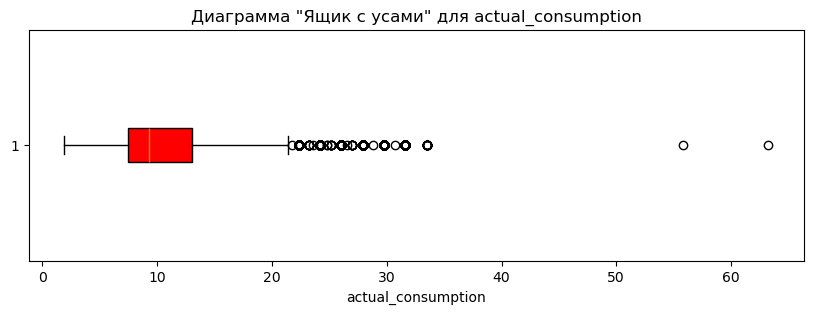

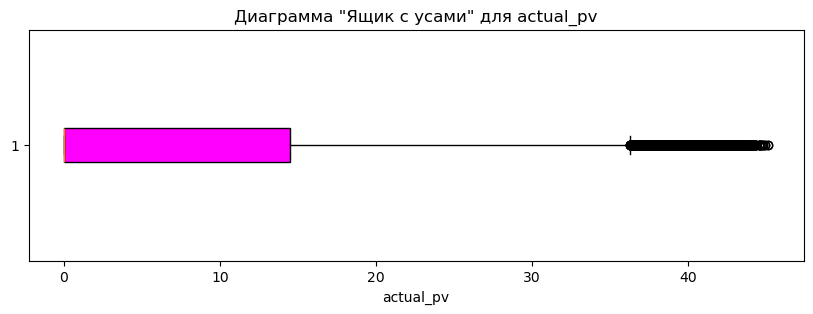

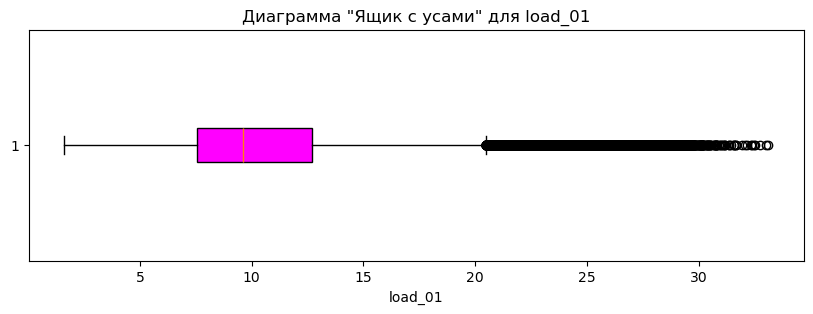

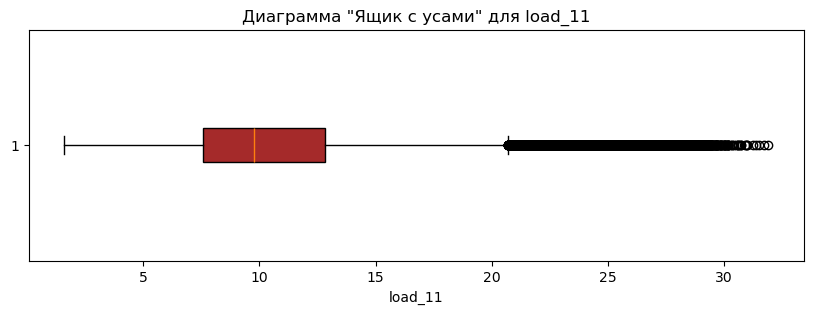

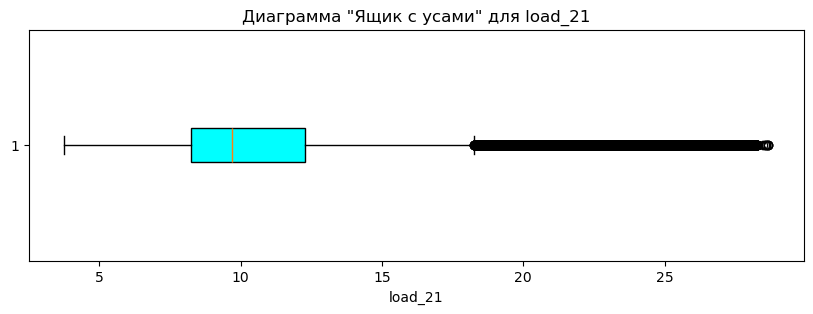

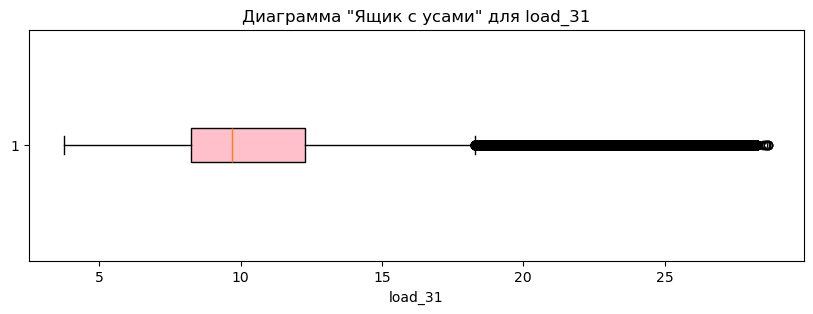

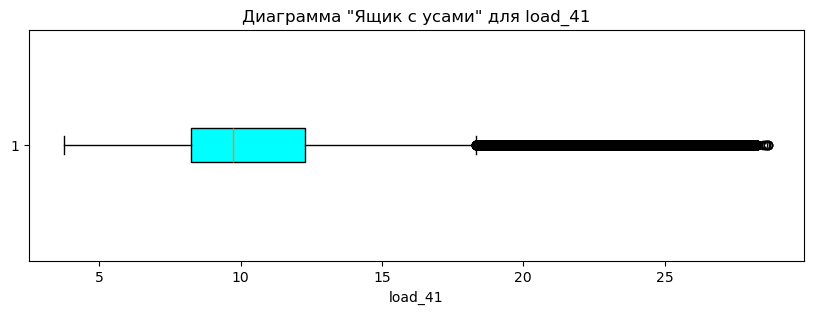

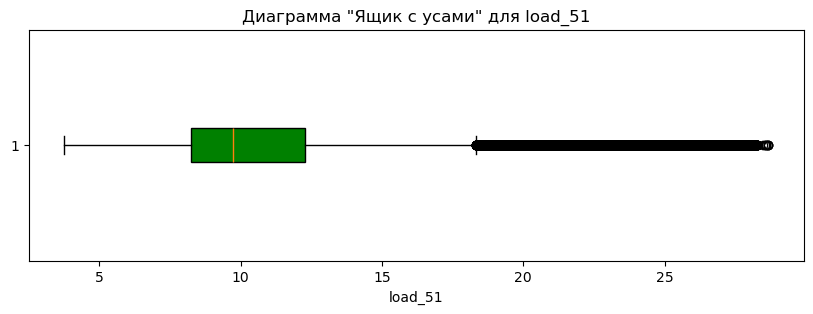

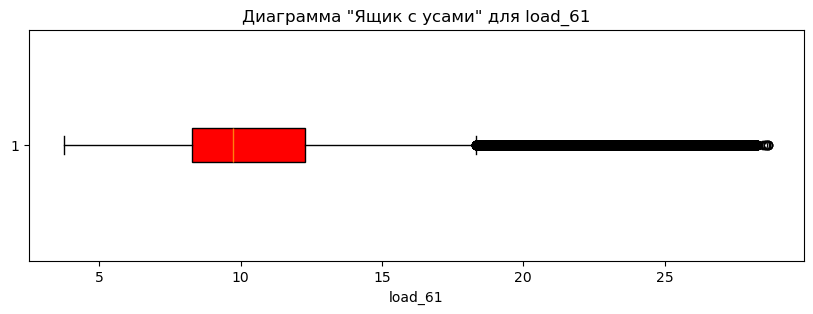

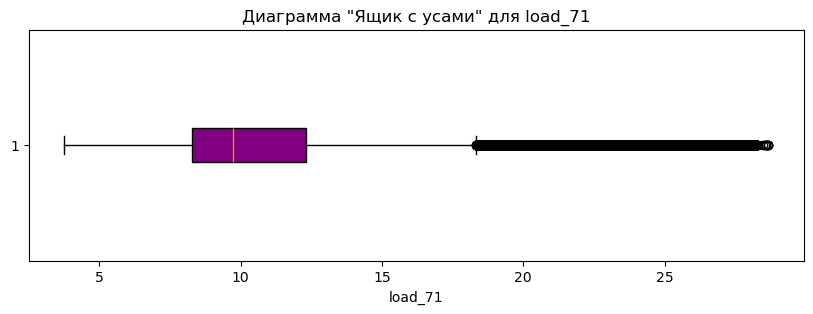

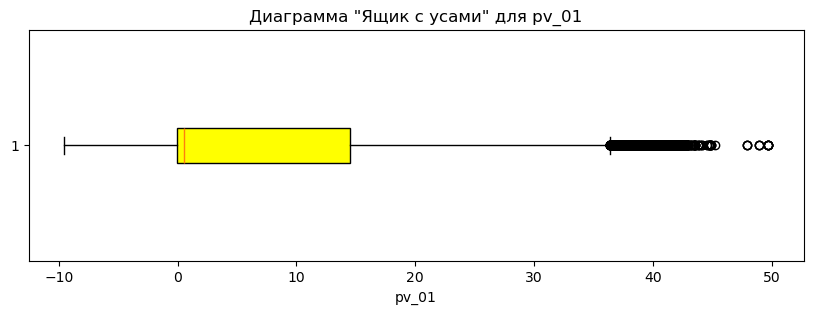

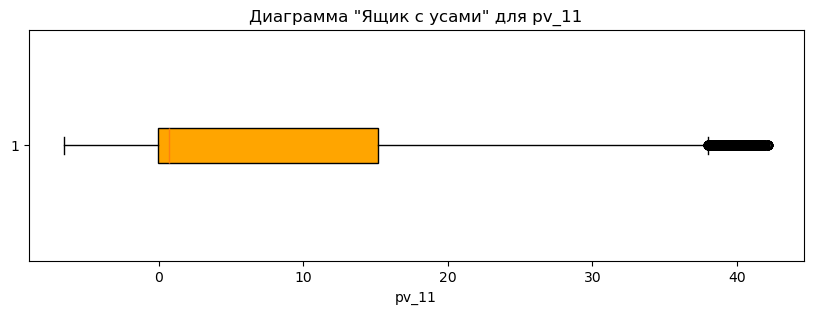

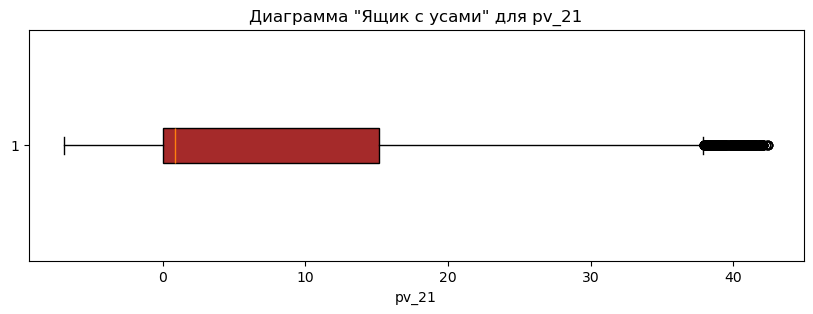

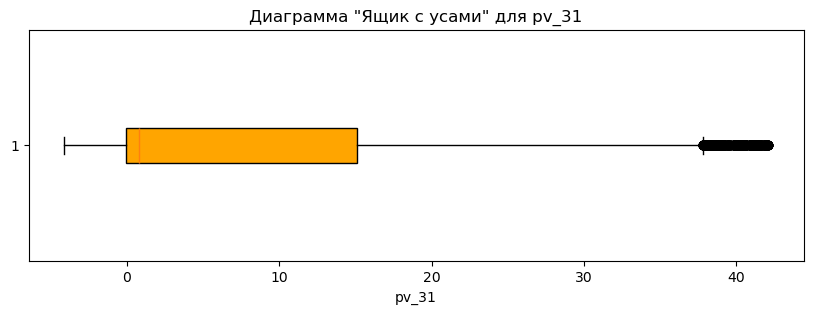

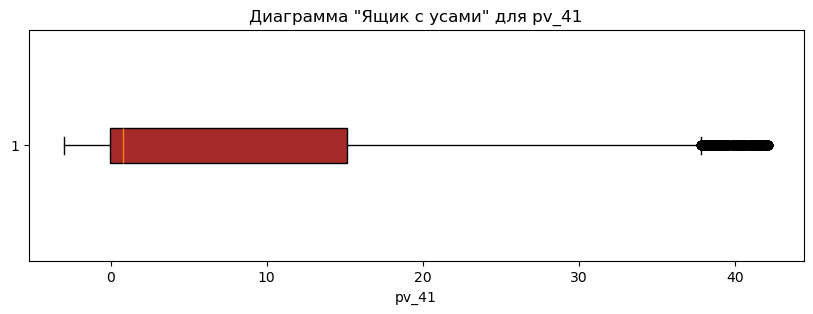

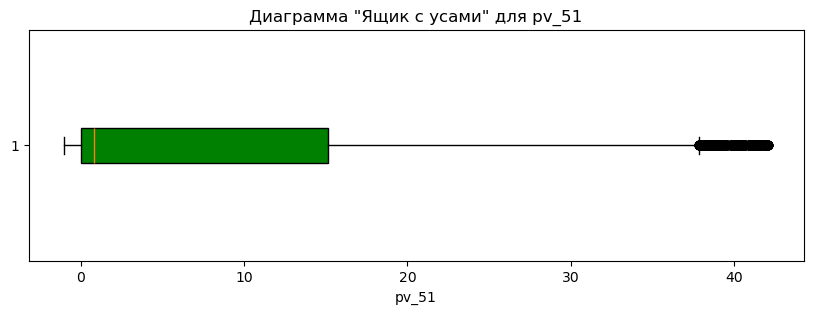

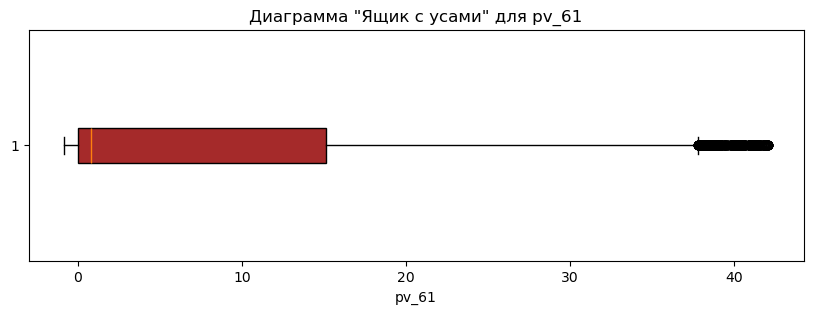

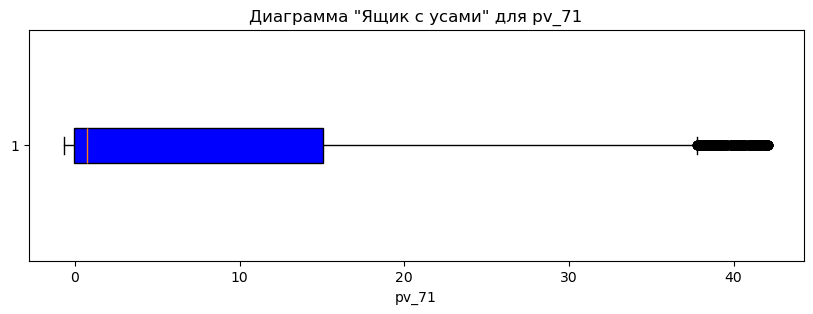

In [5]:
import random
def create_boxplot(dataframe, colomn_name, figsize=(10, 3)):
    column = selected_df.select(colomn_name)

    pandas_df = column.toPandas()
    
    colors = ["red", "green", "blue", "yellow", "orange", "purple", "pink", "cyan", "magenta", "brown"]
    color = random.choice(colors)
    
    plt.figure(figsize=figsize)
    plt.boxplot(pandas_df[colomn_name], vert=False, patch_artist=True, boxprops=dict(facecolor=color))
    plt.title(f'Диаграмма "Ящик с усами" для {colomn_name}')
    plt.xlabel(colomn_name)
    plt.show()

cols = selected_df.columns

for i in cols:
    create_boxplot(selected_df, i)


In [6]:
cleaned_df = selected_df
# общее количество строк до обработки
print('общее количество строк до обработки:', cleaned_df.count())

# ВЫбросы есть везде, поэтому для обработки выбираем все столбцы
columns_for_filter = ["actual_consumption", "actual_pv", "load_01", "load_11", "load_21", "load_31",
                       "load_41", "load_51", "load_61", "load_71", "pv_01", "pv_11", "pv_21", 
                        "pv_31", "pv_41", "pv_51", "pv_61", "pv_71"]

for column in columns_for_filter:
    quartiles = cleaned_df.stat.approxQuantile(column, [0.25, 0.75], 0.0)

    IQR = quartiles[1] - quartiles[0]
    
    # Определение границ для определения выбросов
    lower_bound = quartiles[0] - 1.5 * IQR
    upper_bound = quartiles[1] + 1.5 * IQR

    # Фильтрация данных
    cleaned_df = cleaned_df.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))

# общее количество строк после обработки
print('общее количество строк до обработки:', cleaned_df.count())                                   

общее количество строк до обработки: 91200
общее количество строк до обработки: 25621


## №4. расчетом статистических показателей признаков

In [7]:
# Считаем по всем столбцам
columns = ["actual_consumption", "actual_pv", "load_01", "load_11", "load_21", "load_31",
                       "load_41", "load_51", "load_61", "load_71", "pv_01", "pv_11", "pv_21", 
                        "pv_31", "pv_41", "pv_51", "pv_61", "pv_71"]
stat_df = cleaned_df.describe(columns)
stat_df.toPandas()

,summary,actual_consumption,actual_pv,load_01,load_11,load_21,load_31,load_41,load_51,load_61,load_71,pv_01,pv_11,pv_21,pv_31,pv_41,pv_51,pv_61,pv_71
0,count,25621,25621,25621,25621,25621,25621,25621,25621,25621,25621,25621,25621,25621,25621,25621,25621,25621,25621
1,mean,8.723268824605816,9.811047757299551,8.599220218483792,8.340918499935471,8.57644676232509,8.820230951019804,8.001307058227551,7.723549157604156,7.636625250263446,8.051182594725363,10.534873283634429,13.0505225493496,12.866200745431392,10.539532979658057,8.304473925858693,5.8141524496215755,3.2066235967072263,1.5681458841462648
2,stddev,3.3602958163329233,12.589700266769714,2.832525384660314,3.1254357327308404,3.5708343620948537,4.1314141364091785,2.715844691421227,2.1981591830489684,1.874252198561981,2.204097977981189,12.450625177283753,12.745267165356006,11.81390895250506,11.089487878413058,10.891728770482352,9.460112706937709,6.533690561355079,3.289033880312434
3,min,1.8602995686233044,0.0,1.5945371722497794,1.5945371722497794,3.7455909703381387,3.7455909703381387,3.7455909703381387,3.7455909703381387,4.043818752941206,3.979477768897277,-9.570301480561898,-5.146504246212786,-3.981588870477133,-3.872310645033286,-2.992289211519276,-0.9974095614953334,-0.8667144451478825,-0.6693203987208942
4,max,20.463295254856348,39.723486473029645,18.143612785301762,19.36678919660458,18.64361430776665,19.907014364475042,17.58444585073006,15.787816417604976,15.128979916505825,15.12987719051825,43.12195993609952,42.176911295729155,42.47241547085483,39.620431130977785,37.52741168648374,36.03278171842216,29.313660190777632,14.96027910083786


## №5. визуализацией распределения наиболее важных признаков

<Figure size 800x600 with 0 Axes>

<Axes: ylabel='Frequency'>

Text(0.5, 1.0, 'Distribution of actual_consumption')

Text(0.5, 0, 'actual_consumption')

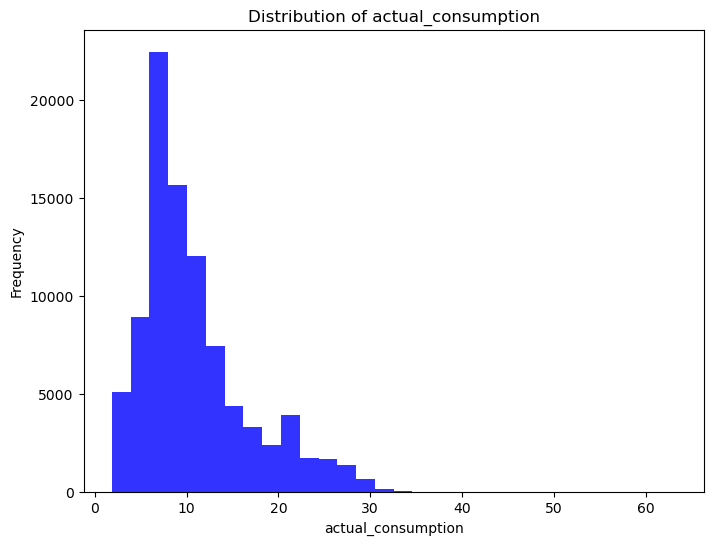

<Figure size 800x600 with 0 Axes>

<Axes: ylabel='Frequency'>

Text(0.5, 1.0, 'Distribution of actual_pv')

Text(0.5, 0, 'actual_pv')

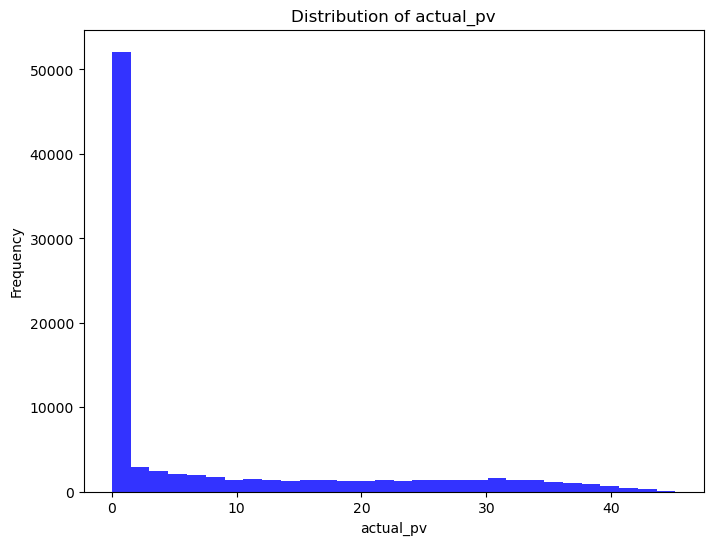

<Figure size 800x600 with 0 Axes>

<Axes: ylabel='Frequency'>

Text(0.5, 1.0, 'Distribution of load_01')

Text(0.5, 0, 'load_01')

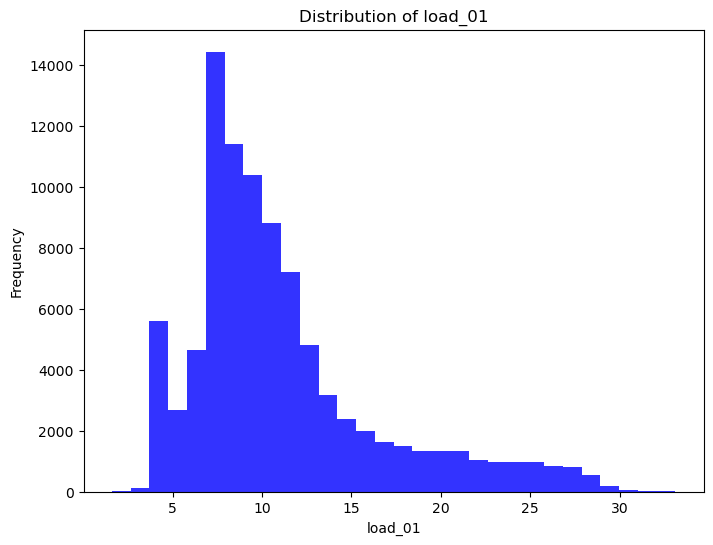

<Figure size 800x600 with 0 Axes>

<Axes: ylabel='Frequency'>

Text(0.5, 1.0, 'Distribution of load_11')

Text(0.5, 0, 'load_11')

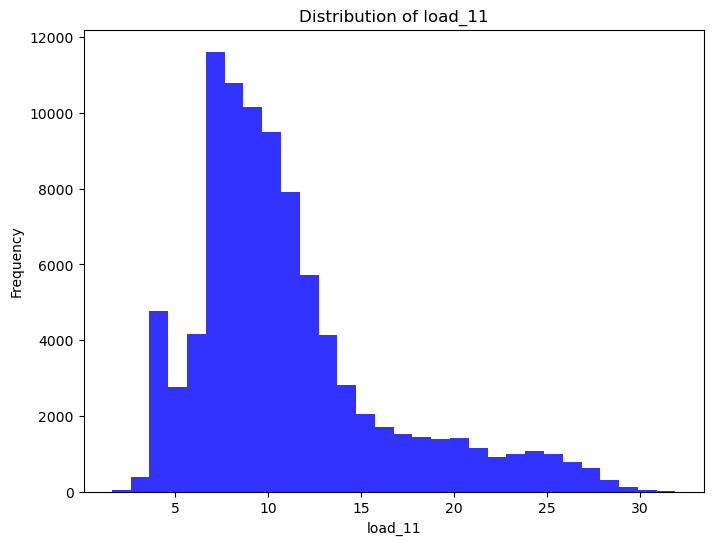

<Figure size 800x600 with 0 Axes>

<Axes: ylabel='Frequency'>

Text(0.5, 1.0, 'Distribution of load_21')

Text(0.5, 0, 'load_21')

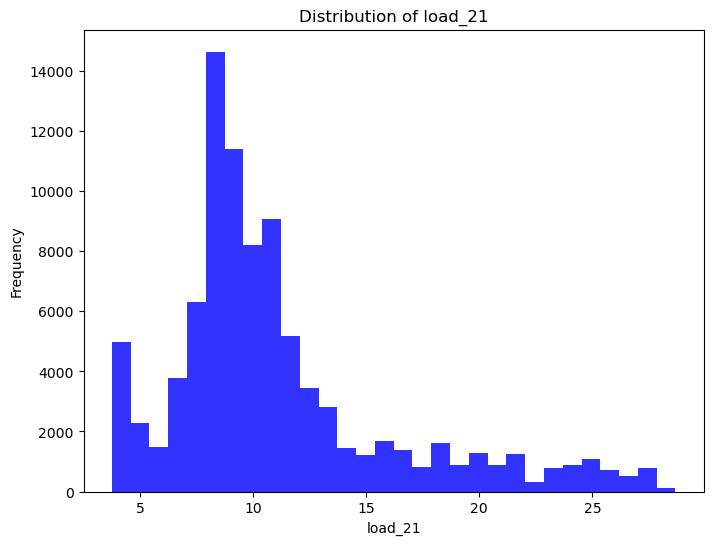

<Figure size 800x600 with 0 Axes>

<Axes: ylabel='Frequency'>

Text(0.5, 1.0, 'Distribution of load_31')

Text(0.5, 0, 'load_31')

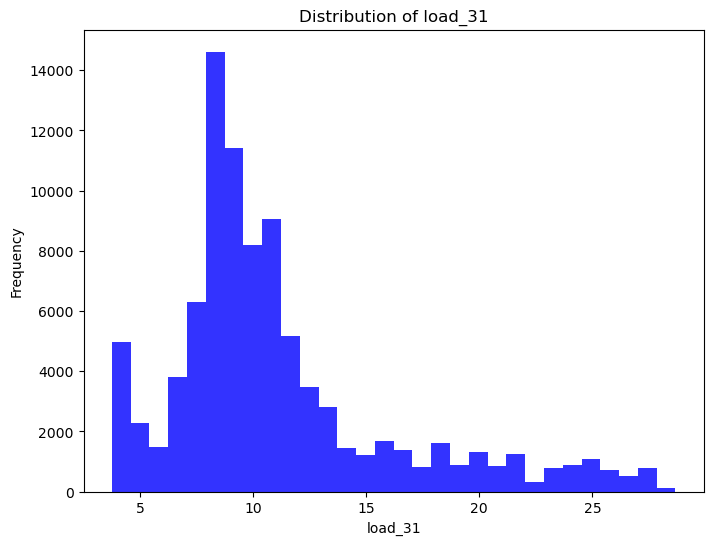

<Figure size 800x600 with 0 Axes>

<Axes: ylabel='Frequency'>

Text(0.5, 1.0, 'Distribution of load_41')

Text(0.5, 0, 'load_41')

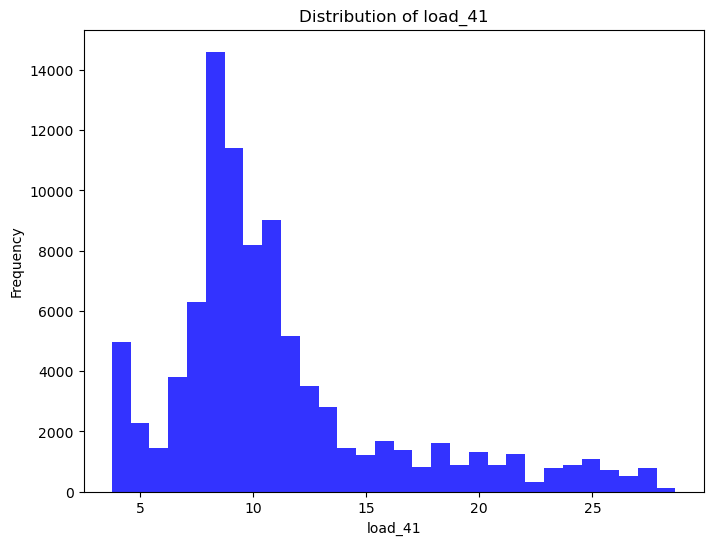

<Figure size 800x600 with 0 Axes>

<Axes: ylabel='Frequency'>

Text(0.5, 1.0, 'Distribution of load_51')

Text(0.5, 0, 'load_51')

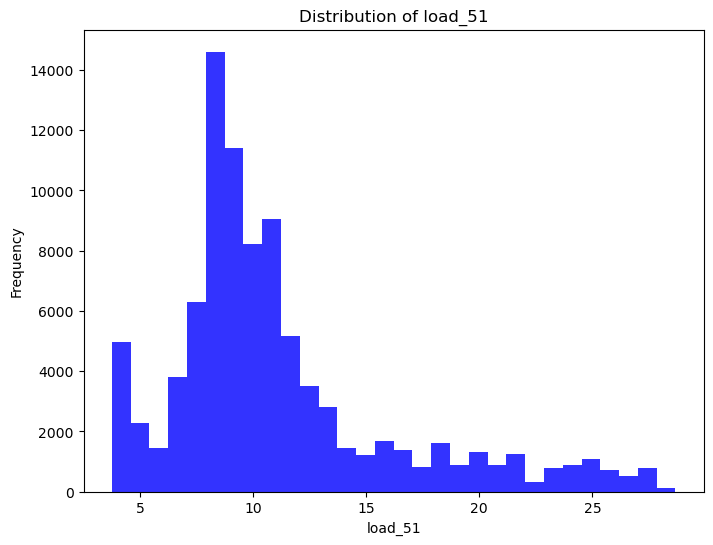

<Figure size 800x600 with 0 Axes>

<Axes: ylabel='Frequency'>

Text(0.5, 1.0, 'Distribution of load_61')

Text(0.5, 0, 'load_61')

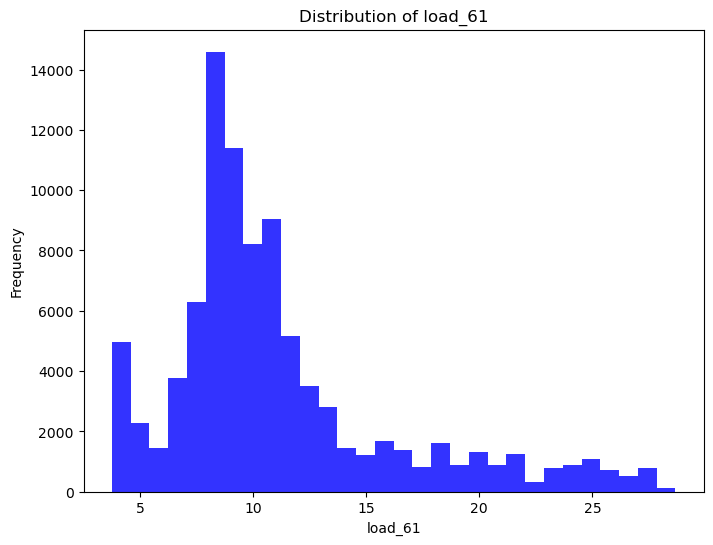

<Figure size 800x600 with 0 Axes>

<Axes: ylabel='Frequency'>

Text(0.5, 1.0, 'Distribution of load_71')

Text(0.5, 0, 'load_71')

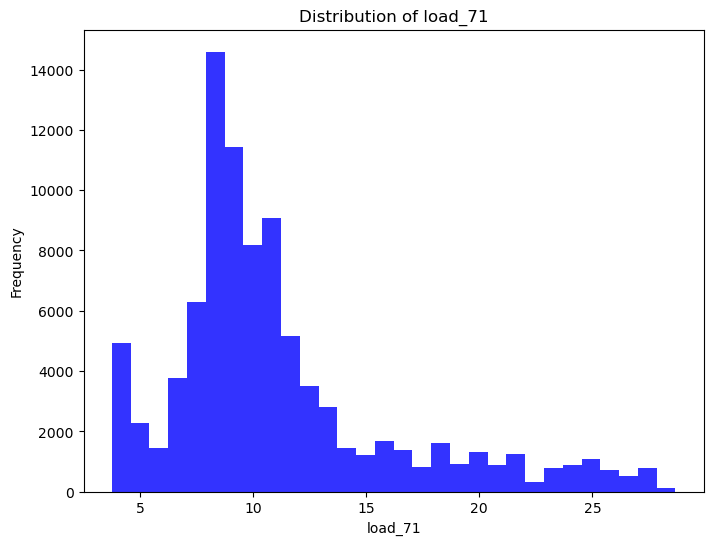

<Figure size 800x600 with 0 Axes>

<Axes: ylabel='Frequency'>

Text(0.5, 1.0, 'Distribution of pv_01')

Text(0.5, 0, 'pv_01')

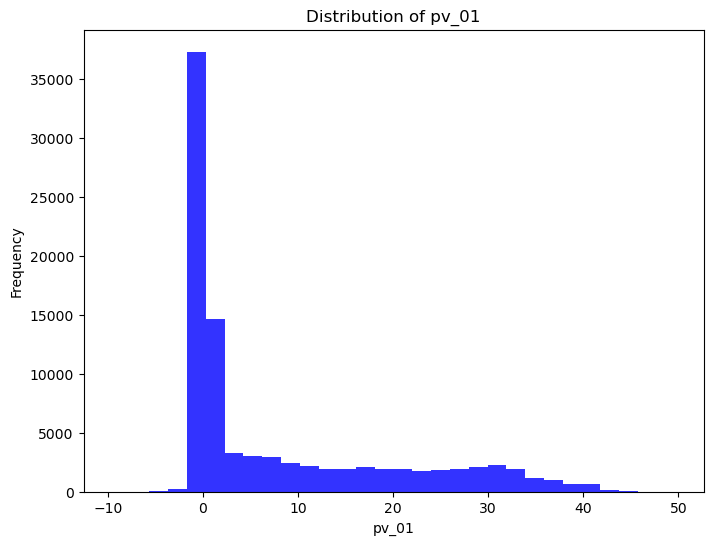

<Figure size 800x600 with 0 Axes>

<Axes: ylabel='Frequency'>

Text(0.5, 1.0, 'Distribution of pv_11')

Text(0.5, 0, 'pv_11')

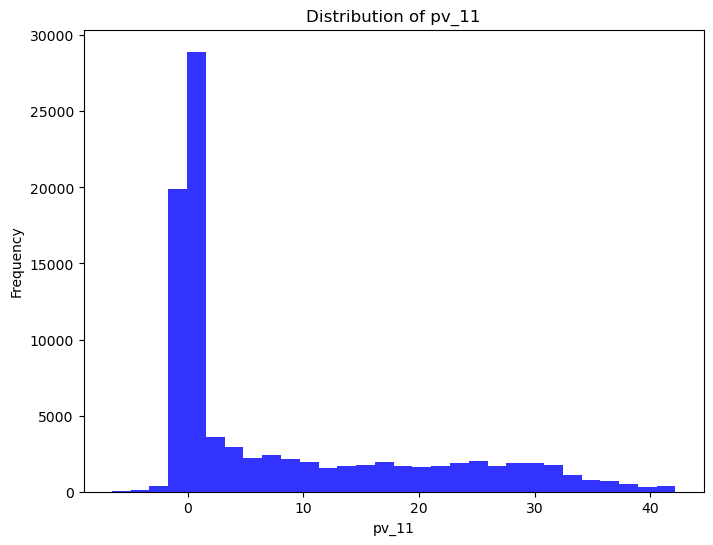

<Figure size 800x600 with 0 Axes>

<Axes: ylabel='Frequency'>

Text(0.5, 1.0, 'Distribution of pv_21')

Text(0.5, 0, 'pv_21')

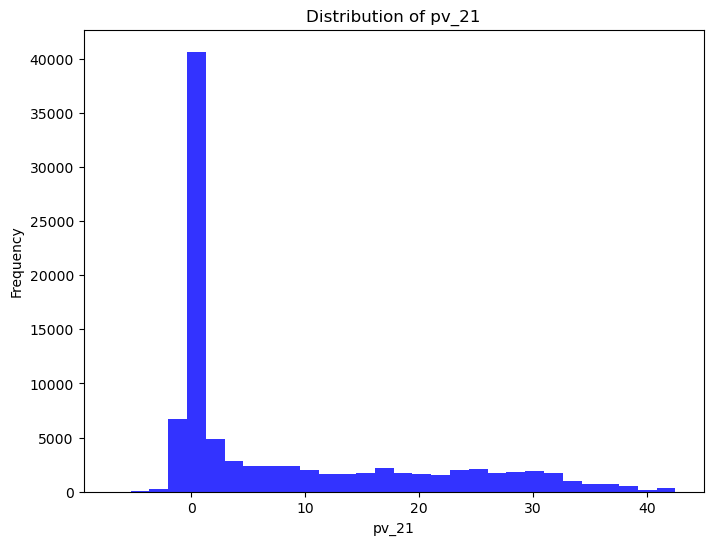

<Figure size 800x600 with 0 Axes>

<Axes: ylabel='Frequency'>

Text(0.5, 1.0, 'Distribution of pv_31')

Text(0.5, 0, 'pv_31')

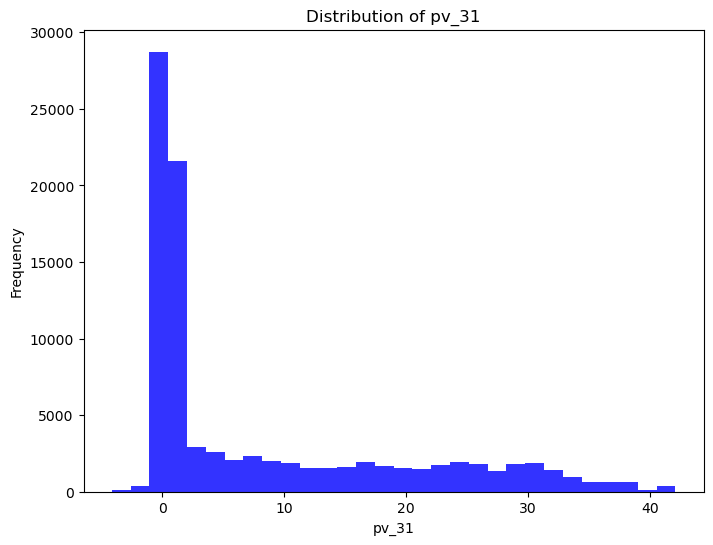

<Figure size 800x600 with 0 Axes>

<Axes: ylabel='Frequency'>

Text(0.5, 1.0, 'Distribution of pv_41')

Text(0.5, 0, 'pv_41')

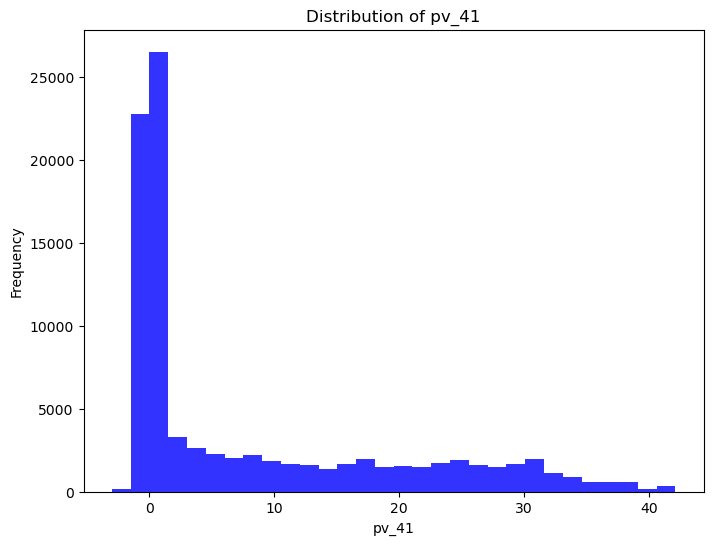

<Figure size 800x600 with 0 Axes>

<Axes: ylabel='Frequency'>

Text(0.5, 1.0, 'Distribution of pv_51')

Text(0.5, 0, 'pv_51')

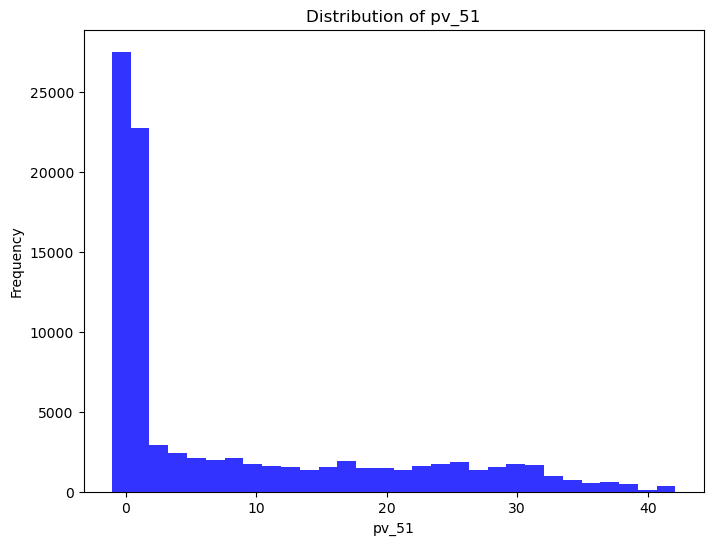

<Figure size 800x600 with 0 Axes>

<Axes: ylabel='Frequency'>

Text(0.5, 1.0, 'Distribution of pv_61')

Text(0.5, 0, 'pv_61')

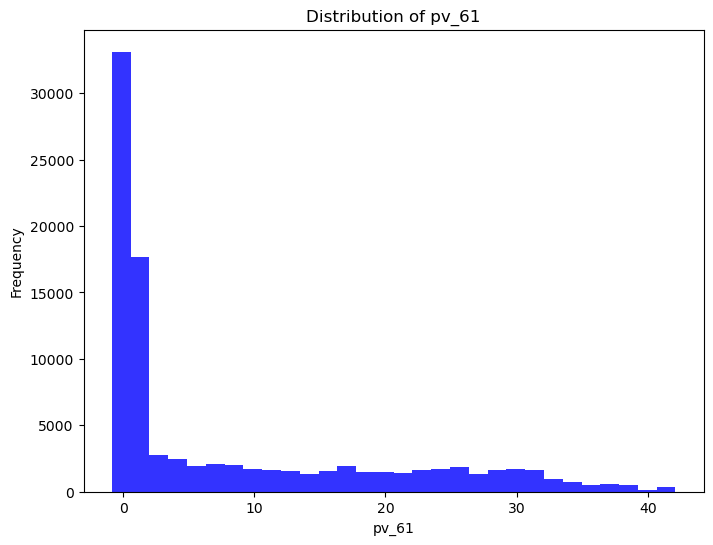

<Figure size 800x600 with 0 Axes>

<Axes: ylabel='Frequency'>

Text(0.5, 1.0, 'Distribution of pv_71')

Text(0.5, 0, 'pv_71')

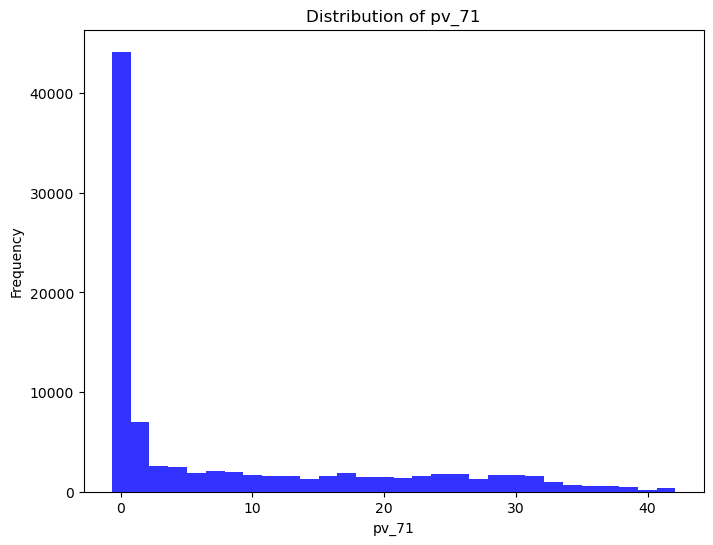

In [8]:
import seaborn as sns
# Визуализация
columns = ["actual_consumption", "actual_pv", "load_01", "load_11", "load_21", "load_31",
                       "load_41", "load_51", "load_61", "load_71", "pv_01", "pv_11", "pv_21", 
                        "pv_31", "pv_41", "pv_51", "pv_61", "pv_71"]

for column in columns:
    plt.figure(figsize=(8, 6))
    df.select(column).toPandas()[column].plot(kind="hist", bins=30, color="blue", alpha=0.8)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.show()

## №6. корреляций между признаками

<Figure size 1000x800 with 0 Axes>

([<matplotlib.axis.XTick at 0x7fc7b230b950>,
 [Text(0, 0, 'actual_consumption'),
  Text(1, 0, 'actual_pv'),
  Text(2, 0, 'load_01'),
  Text(3, 0, 'load_11'),
  Text(4, 0, 'load_21'),
  Text(5, 0, 'load_31'),
  Text(6, 0, 'load_41'),
  Text(7, 0, 'load_51'),
  Text(8, 0, 'load_61'),
  Text(9, 0, 'load_71'),
  Text(10, 0, 'pv_01'),
  Text(11, 0, 'pv_11'),
  Text(12, 0, 'pv_21'),
  Text(13, 0, 'pv_31'),
  Text(14, 0, 'pv_41'),
  Text(15, 0, 'pv_51'),
  Text(16, 0, 'pv_61'),
  Text(17, 0, 'pv_71')])

([<matplotlib.axis.YTick at 0x7fc7aaa6dfd0>,
 [Text(0, 0, 'actual_consumption'),
  Text(0, 1, 'actual_pv'),
  Text(0, 2, 'load_01'),
  Text(0, 3, 'load_11'),
  Text(0, 4, 'load_21'),
  Text(0, 5, 'load_31'),
  Text(0, 6, 'load_41'),
  Text(0, 7, 'load_51'),
  Text(0, 8, 'load_61'),
  Text(0, 9, 'load_71'),
  Text(0, 10, 'pv_01'),
  Text(0, 11, 'pv_11'),
  Text(0, 12, 'pv_21'),
  Text(0, 13, 'pv_31'),
  Text(0, 14, 'pv_41'),
  Text(0, 15, 'pv_51'),
  Text(0, 16, 'pv_61'),
  Text(0, 17, 'pv_71')])

Text(0.5, 1.0, 'Correlation Matrix')

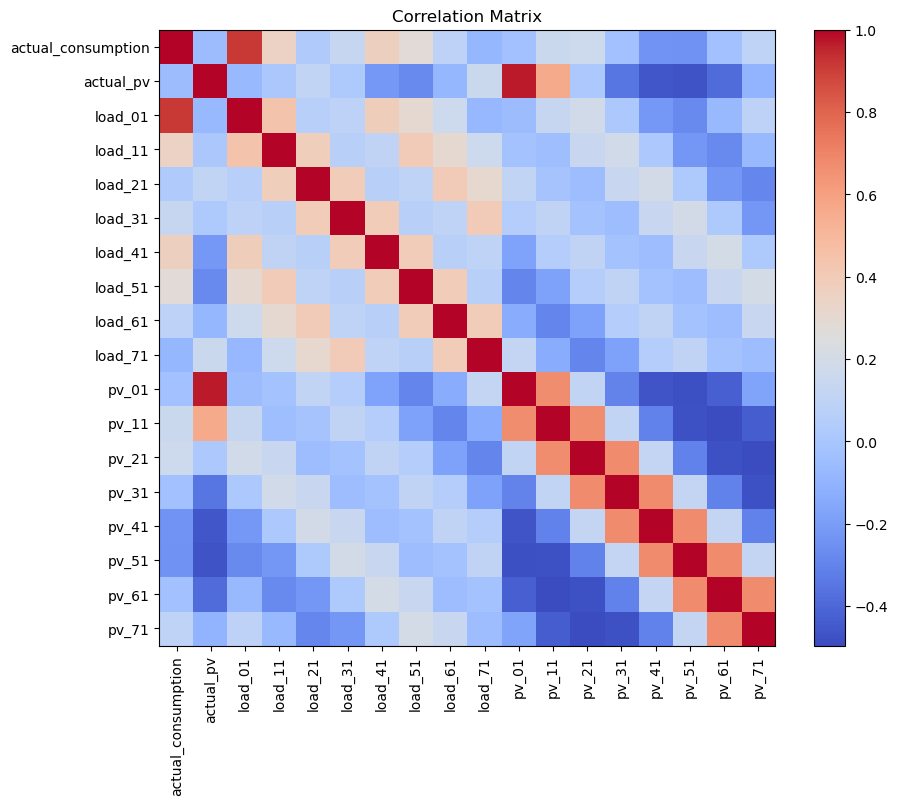

In [9]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

#Собираем объекты в один столбец
assembler = VectorAssembler(inputCols=columns, outputCol="features")
assembled_df = assembler.transform(df)

# Считаем кор. матрицу
cor_m = Correlation.corr(assembled_df, "features").head()

#Извлекаем матрицу в виде массива NumPy
cor_matrix = cor_m[0].toArray()

#График матрицы корреляции
plt.figure(figsize=(10, 8))
plt.imshow(cor_matrix, cmap="coolwarm", interpolation="none")
plt.colorbar()
plt.xticks(range(len(columns)), columns, rotation=90)
plt.yticks(range(len(columns)), columns)
plt.title("Correlation Matrix")
plt.show() 

In [10]:
#Готовим датасет для следующей лабораторной работы 

cleaned_df.toPandas().to_csv('df2.csv')


In [11]:
# Останавливаем сессию Spark
spark.stop()